## USAGE OF oneDNN toolkit from intel oneAPI

### Importing tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

### Importing pandas and numpy

In [17]:
import pandas as pd
import numpy as np

### Installing matplotlib

In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.5 MB/s eta 0:00:00:00:01


In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math

## Importing Dataset

In [8]:
t_test_df = pd.read_csv("normal_test/_annotations.csv")

### Data Preparation

In [9]:
# Set up the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_labels = pd.read_csv('normal_train/train_annotations.csv')
# Convert the column to strings
train_labels['class'] = train_labels['class'].astype(str)
train_generator = train_datagen.flow_from_dataframe(
    train_labels,
    directory='normal_train',
    x_col='filename',
    y_col='class',
    target_size=(300, 300),
    batch_size=32,
    class_mode='sparse')

Found 9756 validated image filenames belonging to 5 classes.


/home/u117015/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3060 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [10]:
from tensorflow.keras.preprocessing.image import load_img

## Creating Model with oneDNN Optimization

In [11]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

In [12]:
# Convolution blocks
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(300,300,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# Classification layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

### COMPILING MODEL : Enable OneDNN optimizations

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 32)        0

## Training the Model

In [ ]:
# training the model

model.fit(train_generator,
          epochs=10,
          steps_per_epoch=9756//32)

Epoch 1/10
304/304 [==============================] - 113s 370ms/step - loss: 1.4351 - accuracy: 0.3415
Epoch 2/10
304/304 [==============================] - 105s 344ms/step - loss: 1.3795 - accuracy: 0.3426
Epoch 3/10
304/304 [==============================] - 107s 350ms/step - loss: 1.3555 - accuracy: 0.3468
Epoch 4/10
304/304 [==============================] - 107s 351ms/step - loss: 1.3351 - accuracy: 0.3458
Epoch 5/10
304/304 [==============================] - 107s 351ms/step - loss: 1.3129 - accuracy: 0.3492
Epoch 6/10
158/304 [==============>...............] - ETA: 51s - loss: 1.3009 - accuracy: 0.3486

In [12]:
# Create a generator for the test images
t_test_datagen = ImageDataGenerator(rescale=1./255)
t_test_generator = t_test_datagen.flow_from_dataframe(
    t_test_df,
    directory="normal_test",
    x_col='filename',
    y_col=None,
    target_size=(300, 300),
    batch_size=32,
    class_mode=None,
    shuffle=False)

# Use the trained model to make predictions on the test data
preds = model.predict_generator(t_test_generator, steps=None)

# Remove any missing filenames from the test CSV file
missing_filenames = set(t_test_generator.filenames) - set(t_test_df['filename'])
if missing_filenames:
    print(f'Removing {len(missing_filenames)} missing filenames from the test CSV file.')
    t_test_df = t_test_df[~t_test_df['filename'].isin(missing_filenames)]

Found 823 validated image filenames.


/tmp/ipykernel_470662/3099137531.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(t_test_generator, steps=None)


## Testing Predictions

In [13]:
import keras.utils as ku
import numpy as np

In [17]:
labels = (train_generator.class_indices)
print(labels,'\n')

{'helmet': 0, 'no-helmet': 1, 'no-vest': 2, 'person': 3, 'vest': 4} 



1/1 [==============================] - 0s 27ms/step
Probability: 0.37528387
Classified: [3] 



Text(0.5, 1.0, 'Loaded Image')

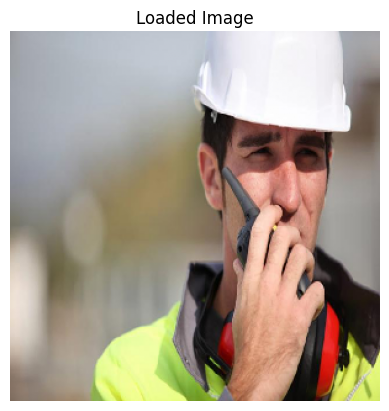

In [16]:
test_img = 'normal_test/ppe_0013_jpg.rf.18939fd36f7cd962143717edf018372b.jpg'
img = ku.load_img(test_img, target_size = (300,300))
img = ku.img_to_array(img, dtype=np.uint8)
img = np.array(img)/255.0
prediction = model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Probability:",np.max(prediction[0], axis=-1))
predicted_class = [np.argmax(prediction[0], axis=-1)]
print("Classified:",predicted_class,'\n')

plt.axis('off')
plt.imshow(img.squeeze())
plt.title("Loaded Image")

### Saving the Trained Model

In [15]:
model.save('oneDNN.h5')

/home/u117015/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
